In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download Dataset and split into reference dataset and query dataset

In [4]:
adata = sc.read('pbmc_vars_sb.h5ad')

In [5]:
adata = adata[adata.obs['study']!='Villani'].copy()

In [6]:
adata.X = adata.layers["counts"].copy()

In [7]:
sca.add_annotations(adata, 'c2.cp.reactome.v4.0.symbols.gmt', min_genes=12)

In [8]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [9]:
sc.pp.normalize_total(adata)

In [10]:
sc.pp.log1p(adata)

In [11]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [12]:
select_terms = adata.varm['I'].sum(0)>12

In [13]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [14]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [15]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [16]:
adata.X-=adata.X.mean(0)

In [17]:
adata.X = adata.layers["counts"].copy()

### Create TRVAE model and train it on reference dataset

In [18]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[1000, 600, 600],
    use_mmd=False,
    recon_loss='nb',
    mask=adata.varm['I'].T,
    use_decoder_relu=False,
    mmd_instead_kl=False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 1000 4
	Hidden Layer 1 in/out: 1000 600
	Hidden Layer 2 in/out: 600 600
	Mean/Var Layer in/out: 600 282
Decoder Architecture:
	Masked linear layer in, out and cond:  282 1972 4


In [19]:
ALPHA = 0.7

In [20]:
OMEGA = torch.Tensor(adata.varm['I'].sum(0))
OMEGA/=OMEGA.max()
OMEGA*=10

In [21]:
OMEGA = None

In [22]:
LR = 0.0001

In [23]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=500, 
    alpha_epoch_anneal=200, 
    alpha=ALPHA, 
    omega=OMEGA,
    alpha_kl=0.001,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    seed=2021
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Number of deactivated terms: 4
 |--------------------| 0.2%  - epoch_loss: 5607.99 - epoch_recon_loss: 5607.99 - epoch_kl_loss: 15758.36 - val_loss: 5373.49 - val_recon_loss: 5373.49 - val_kl_loss: 23067.98
Number of deactivated terms: 30
 |--------------------| 0.4%  - epoch_loss: 4669.48 - epoch_recon_loss: 4669.34 - epoch_kl_loss: 27218.30 - val_loss: 5048.39 - val_recon_loss: 5048.24 - val_kl_loss: 31215.06
Number of deactivated terms: 39
 |--------------------| 0.6%  - epoch_loss: 4460.48 - epoch_recon_loss: 4460.14 - epoch_kl_loss: 34827.75 - val_loss: 4848.72 - val_recon_loss: 4848.34 - val_kl_loss: 37873.40
Number of deactivated terms: 36
 |--------------------| 0.8%  - epoch_loss: 4218.40 - epoch_recon_loss: 4217.80 - epoch_kl_loss: 40335.19 - val_loss: 4595.92 - val_recon_loss: 4595.28 - val_kl_loss: 42690.56
Number of deactivated terms: 39
 |--------------------| 1.0%  - epoch_loss: 4083.92 - epoch_recon_loss: 4083.03 - epoch_kl_loss: 44357.74 - val_loss: 4392.86 - val_recon

 |███-----------------| 15.8%  - epoch_loss: 1984.41 - epoch_recon_loss: 1980.95 - epoch_kl_loss: 8882.43 - val_loss: 2158.89 - val_recon_loss: 2155.55 - val_kl_loss: 8552.62
Number of deactivated terms: 32
 |███-----------------| 16.0%  - epoch_loss: 1980.65 - epoch_recon_loss: 1977.18 - epoch_kl_loss: 8782.56 - val_loss: 2157.40 - val_recon_loss: 2154.05 - val_kl_loss: 8494.58
Number of deactivated terms: 24
 |███-----------------| 16.2%  - epoch_loss: 1977.81 - epoch_recon_loss: 1974.33 - epoch_kl_loss: 8705.01 - val_loss: 2167.51 - val_recon_loss: 2164.21 - val_kl_loss: 8265.45
Number of deactivated terms: 20
 |███-----------------| 16.4%  - epoch_loss: 1986.81 - epoch_recon_loss: 1983.32 - epoch_kl_loss: 8612.33 - val_loss: 2161.52 - val_recon_loss: 2158.17 - val_kl_loss: 8271.85
Number of deactivated terms: 26
 |███-----------------| 16.6%  - epoch_loss: 1966.83 - epoch_recon_loss: 1963.33 - epoch_kl_loss: 8524.76 - val_loss: 2160.77 - val_recon_loss: 2157.40 - val_kl_loss: 8231.

 |██████--------------| 31.4%  - epoch_loss: 1970.29 - epoch_recon_loss: 1965.49 - epoch_kl_loss: 6158.51 - val_loss: 2143.16 - val_recon_loss: 2138.84 - val_kl_loss: 5536.48
Number of deactivated terms: 32
 |██████--------------| 31.6%  - epoch_loss: 1953.30 - epoch_recon_loss: 1948.49 - epoch_kl_loss: 6119.75 - val_loss: 2149.86 - val_recon_loss: 2145.60 - val_kl_loss: 5426.39
Number of deactivated terms: 22
 |██████--------------| 31.8%  - epoch_loss: 1945.57 - epoch_recon_loss: 1940.75 - epoch_kl_loss: 6101.21 - val_loss: 2137.29 - val_recon_loss: 2133.02 - val_kl_loss: 5401.34
Number of deactivated terms: 25
 |██████--------------| 32.0%  - epoch_loss: 1952.04 - epoch_recon_loss: 1947.20 - epoch_kl_loss: 6088.79 - val_loss: 2136.81 - val_recon_loss: 2132.51 - val_kl_loss: 5416.14
Number of deactivated terms: 20
 |██████--------------| 32.2%  - epoch_loss: 1972.82 - epoch_recon_loss: 1967.97 - epoch_kl_loss: 6069.73 - val_loss: 2143.85 - val_recon_loss: 2139.48 - val_kl_loss: 5461.

 |█████████-----------| 47.0%  - epoch_loss: 1950.29 - epoch_recon_loss: 1944.89 - epoch_kl_loss: 5398.88 - val_loss: 2133.47 - val_recon_loss: 2128.75 - val_kl_loss: 4713.84
Number of deactivated terms: 31
 |█████████-----------| 47.2%  - epoch_loss: 1963.52 - epoch_recon_loss: 1958.13 - epoch_kl_loss: 5391.70 - val_loss: 2133.98 - val_recon_loss: 2129.28 - val_kl_loss: 4707.32
Number of deactivated terms: 26
 |█████████-----------| 47.4%  - epoch_loss: 1953.49 - epoch_recon_loss: 1948.07 - epoch_kl_loss: 5417.38 - val_loss: 2128.83 - val_recon_loss: 2124.14 - val_kl_loss: 4699.11
Number of deactivated terms: 25
 |█████████-----------| 47.6%  - epoch_loss: 1957.87 - epoch_recon_loss: 1952.45 - epoch_kl_loss: 5419.88 - val_loss: 2140.56 - val_recon_loss: 2135.85 - val_kl_loss: 4713.17
Number of deactivated terms: 21
 |█████████-----------| 47.8%  - epoch_loss: 1954.09 - epoch_recon_loss: 1948.68 - epoch_kl_loss: 5416.80 - val_loss: 2132.10 - val_recon_loss: 2127.38 - val_kl_loss: 4714.

In [22]:
inactive_idx = ~(intr_cvae.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()

In [25]:
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

Inactive terms:


['FORMATION_OF_THE_TERNARY_COMPL',
 'O_LINKED_GLYCOSYLATION_OF_MUCI',
 'RIP_MEDIATED_NFKB_ACTIVATION_V',
 'YAP1_AND_WWTR1_TAZ_STIMULATED_',
 'ACTIVATION_OF_THE_MRNA_UPON_BI',
 'ERK_MAPK_TARGETS',
 'CA_DEPENDENT_EVENTS',
 'CYCLIN_E_ASSOCIATED_EVENTS_DUR',
 'P53_DEPENDENT_G1_DNA_DAMAGE_RE',
 'FORMATION_OF_RNA_POL_II_ELONGA',
 'G_PROTEIN_BETA_GAMMA_SIGNALLIN',
 'CTLA4_INHIBITORY_SIGNALING',
 'ACTIVATION_OF_NMDA_RECEPTOR_UP',
 'TAK1_ACTIVATES_NFKB_BY_PHOSPHO',
 'ACTIVATION_OF_KAINATE_RECEPTOR',
 'ACTIVATED_TAK1_MEDIATES_P38_MA',
 'EFFECTS_OF_PIP2_HYDROLYSIS',
 'REGULATION_OF_SIGNALING_BY_CBL',
 'APC_C_CDC20_MEDIATED_DEGRADATI']

In [25]:
MEAN = True

In [27]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [28]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [29]:
sc.tl.umap(adata)

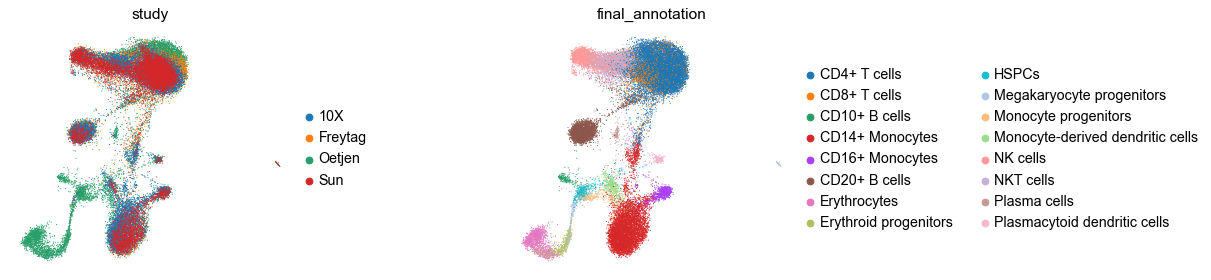

In [30]:
sc.pl.umap(adata, color=['study', 'final_annotation'], frameon=False, wspace=0.6)

In [31]:
#intr_cvae.save('intr_cvae_nb_mmd_beta_15')

In [18]:
kang = sc.read('kang_count.h5ad')[:, adata.var_names].copy()

In [19]:
kang.obs['study'] = 'Kang'

In [32]:
# for mse
sc.pp.normalize_total(kang)
sc.pp.log1p(kang)
kang.X-=kang.X.mean(0)

In [21]:
#q_intr_cvae = sca.models.TRVAE.load('q_intr_cvae_nb_alpha_kl_0_001_sd_2021', kang)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 1000 5
	Hidden Layer 1 in/out: 1000 600
	Hidden Layer 2 in/out: 600 600
	Mean/Var Layer in/out: 600 282
Decoder Architecture:
	Masked linear layer in, out and cond:  282 1972 5


In [34]:
q_intr_cvae = sca.models.TRVAE.load_query_data(kang, intr_cvae)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 1000 5
	Hidden Layer 1 in/out: 1000 600
	Hidden Layer 2 in/out: 600 600
	Mean/Var Layer in/out: 600 282
Decoder Architecture:
	Masked linear layer in, out and cond:  282 1972 5


In [35]:
q_intr_cvae.train(n_epochs=500, alpha_epoch_anneal=200, weight_decay=0., alpha_kl=0.001, seed=2021)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |█████████-----------| 49.2%  - epoch_loss: 1024.82 - epoch_recon_loss: 1020.12 - epoch_kl_loss: 4697.48 - val_loss: 1020.36 - val_recon_loss: 1015.68 - val_kl_loss: 4680.86
ADJUSTED LR
 |██████████----------| 52.0%  - epoch_loss: 1022.60 - epoch_recon_loss: 1017.91 - epoch_kl_loss: 4692.22 - val_loss: 1020.22 - val_recon_loss: 1015.54 - val_kl_loss: 4680.60
ADJUSTED LR
 |██████████----------| 53.4%  - epoch_loss: 1021.43 - epoch_recon_loss: 1016.74 - epoch_kl_loss: 4687.32 - val_loss: 1019.68 - val_recon_loss: 1015.00 - val_kl_loss: 4679.09
ADJUSTED LR
 |███████████---------| 55.6%  - epoch_loss: 1025.48 - epoch_recon_loss: 1020.79 - epoch_kl_loss: 4694.42 - val_loss: 1020.84 - val_recon_loss: 1016.16 - val_kl_loss: 4680.46
ADJUSTED LR
 |███████████---------| 57.0%  - epoch_loss: 1021.05 - epoch_recon_loss: 1016.36 - epoch_kl_loss: 4692.83 - val_loss: 1020.71 - val_recon_loss: 1016.03 - val_kl_loss: 4683.03
ADJUSTED LR
 |███████████---------| 58.2%  - epoch_loss: 1015.67 - epoch_reco

In [70]:
#q_intr_cvae.save('q_intr_cvae_nb_alpha_kl_0_001_sd_2021')

In [36]:
kang.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [37]:
sc.pp.neighbors(kang, use_rep='X_cvae')

In [38]:
sc.tl.umap(kang)

... storing 'study' as categorical


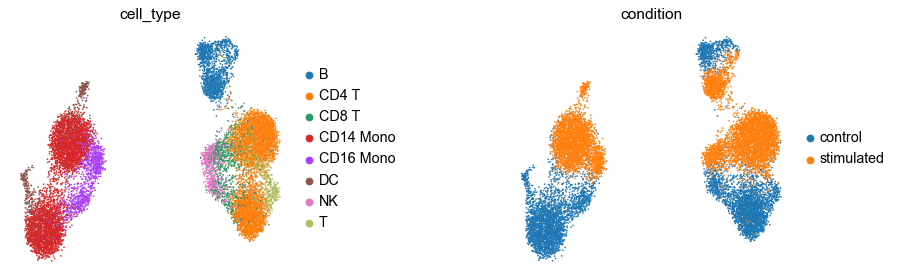

In [39]:
sc.pl.umap(kang, color=['cell_type', 'condition'], frameon=False, wspace=0.6)

In [40]:
terms = adata.uns['terms']

In [41]:
terms

['TRANSLATION',
 'PYRUVATE_METABOLISM_AND_CITRIC',
 'APOPTOTIC_CLEAVAGE_OF_CELLULAR',
 'FORMATION_OF_THE_TERNARY_COMPL',
 'SIGNALING_BY_RHO_GTPASES',
 'SIGNALING_BY_WNT',
 'SIGNALLING_BY_NGF',
 'SIGNALING_BY_SCF_KIT',
 'DEVELOPMENTAL_BIOLOGY',
 'DAG_AND_IP3_SIGNALING',
 'TCA_CYCLE_AND_RESPIRATORY_ELEC',
 'BMAL1_CLOCK_NPAS2_ACTIVATES_CI',
 'ANTIGEN_PROCESSING_CROSS_PRESE',
 'GROWTH_HORMONE_RECEPTOR_SIGNAL',
 'TRIF_MEDIATED_TLR3_SIGNALING',
 'CELL_CELL_COMMUNICATION',
 'ER_PHAGOSOME_PATHWAY',
 'MEIOSIS',
 'MEMBRANE_TRAFFICKING',
 'NEF_MEDIATES_DOWN_MODULATION_O',
 'IMMUNOREGULATORY_INTERACTIONS_',
 'METABOLISM_OF_VITAMINS_AND_COF',
 'TRANS_GOLGI_NETWORK_VESICLE_BU',
 'CELL_CYCLE',
 'SIGNALING_BY_ERBB4',
 'ORC1_REMOVAL_FROM_CHROMATIN',
 'O_LINKED_GLYCOSYLATION_OF_MUCI',
 'ANTIVIRAL_MECHANISM_BY_IFN_STI',
 'SIGNALING_BY_ERBB2',
 'SPHINGOLIPID_DE_NOVO_BIOSYNTHE',
 'SIGNALING_BY_EGFR_IN_CANCER',
 'SRP_DEPENDENT_COTRANSLATIONAL_',
 'PI3K_EVENTS_IN_ERBB4_SIGNALING',
 'PI3K_EVENTS_IN_ERBB2_SIGN

In [42]:
idx = [terms.index(term) for term in ['INTERFERON_SIGNALING', 'SIGNALING_BY_THE_B_CELL_RECEPT', 'INTERFERON_ALPHA_BETA_SIGNALIN']]

In [43]:
latents = q_intr_cvae.get_latent(mean=MEAN)[:, idx]

In [44]:
kang.obs['INTERFERON_SIGNALING'] = latents[:, 0]
kang.obs['SIGNALING_BY_THE_B_CELL_RECEPT'] = latents[:, 1]
kang.obs['INTERFERON_ALPHA_BETA_SIGNALIN'] = latents[:, 2]

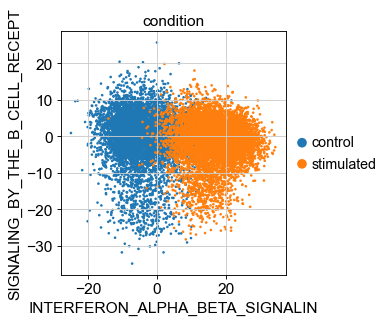

In [45]:
sc.pl.scatter(kang, x='INTERFERON_ALPHA_BETA_SIGNALIN', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition', size=22)

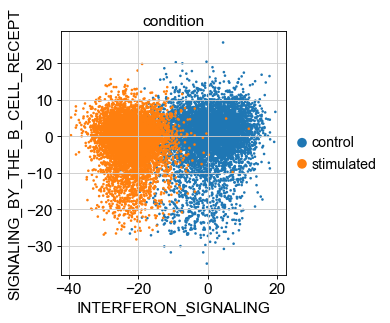

In [46]:
sc.pl.scatter(kang, x='INTERFERON_SIGNALING', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition', size=22)

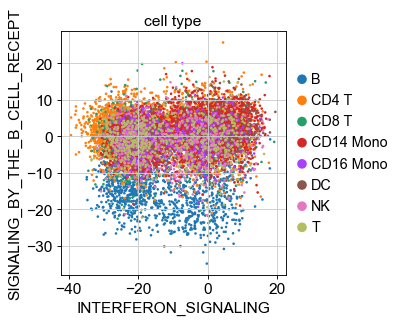

In [47]:
sc.pl.scatter(kang, x='INTERFERON_SIGNALING', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='cell_type', size=22)

In [48]:
latents = intr_cvae.get_latent(mean=MEAN)[:, idx]

In [49]:
adata.obs['INTERFERON_SIGNALING'] = latents[:, 0]
adata.obs['SIGNALING_BY_THE_B_CELL_RECEPT'] = latents[:, 1]

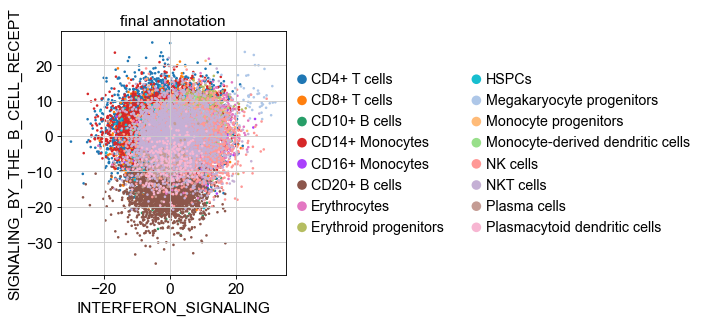

In [50]:
sc.pl.scatter(adata, x='INTERFERON_SIGNALING', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='final_annotation', size=22)

In [23]:
kang_pbmc = sc.AnnData.concatenate(adata, kang, batch_key='batch_join')

In [26]:
kang_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'].tolist(), mean=MEAN)[:, ~inactive_idx]

In [53]:
sc.pp.neighbors(kang_pbmc, use_rep='X_cvae')
sc.tl.umap(kang_pbmc)

In [27]:
kang_pbmc.strings_to_categoricals()

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'final_annotation' as categorical
... storing 'sample_ID' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'orig.ident' as categorical
... storing 'stim' as categorical
... storing 'seurat_annotations' as categorical
... storing 'condition' as categorical
... storing 'cell_type' as categorical


In [28]:
kang_pbmc.obs['cell_type_joint'] = kang_pbmc.obs['final_annotation'].tolist()

In [29]:
idx_1 = kang_pbmc.obs['cell_type_joint'] == 'nan'
idx_2 = kang_pbmc.obs['cell_type'] != 'nan'
kang_pbmc.obs['cell_type_joint'][idx_1] = kang_pbmc.obs['cell_type'][idx_2].tolist()

In [30]:
categories = np.unique(kang_pbmc.obs['cell_type_joint'])

In [31]:
categories

array(['B', 'CD10+ B cells', 'CD14 Mono', 'CD14+ Monocytes', 'CD16 Mono',
       'CD16+ Monocytes', 'CD20+ B cells', 'CD4 T', 'CD4+ T cells',
       'CD8 T', 'CD8+ T cells', 'DC', 'Erythrocytes',
       'Erythroid progenitors', 'HSPCs', 'Megakaryocyte progenitors',
       'Monocyte progenitors', 'Monocyte-derived dendritic cells', 'NK',
       'NK cells', 'NKT cells', 'Plasma cells',
       'Plasmacytoid dendritic cells', 'T'], dtype=object)

In [32]:
celltypes_replace = {}
celltypes_replace['CD20+ B cells'] = 'B'
celltypes_replace['CD4 T'] = 'CD4+ T cells'
celltypes_replace['CD8 T'] = 'CD8+ T cells'
celltypes_replace['CD14 Mono'] = 'CD14+ Monocytes'
celltypes_replace['CD16 Mono'] = 'CD16+ Monocytes'
celltypes_replace['NK'] = 'NK cells'

In [33]:
for cat in categories:
    if cat in celltypes_replace:
        kang_pbmc.obs['cell_type_joint'][kang_pbmc.obs['cell_type_joint']==cat] = celltypes_replace[cat]

... storing 'cell_type_joint' as categorical


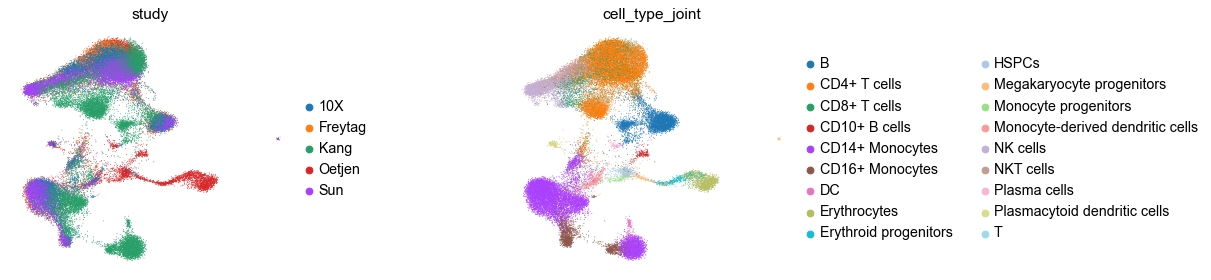

In [61]:
sc.pl.umap(kang_pbmc, color=['study', 'cell_type_joint'], frameon=False, wspace=0.6)

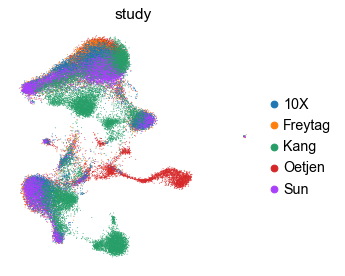

In [62]:
sc.pl.umap(kang_pbmc, color='study', frameon=False, wspace=0.6)

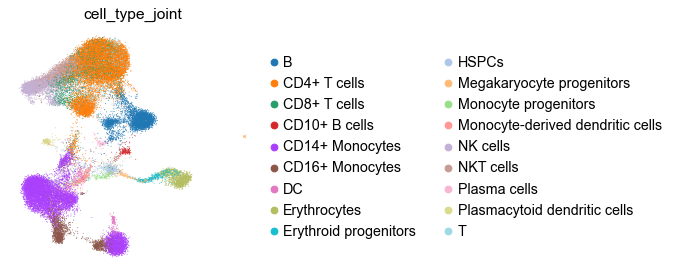

In [63]:
sc.pl.umap(kang_pbmc, color='cell_type_joint', frameon=False, wspace=0.6)

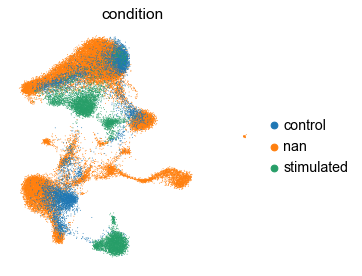

In [64]:
sc.pl.umap(kang_pbmc, color='condition', frameon=False, wspace=0.6)

In [34]:
#kang_pbmc.write('kang_pbmc.h5ad')

... storing 'cell_type_joint' as categorical


In [65]:
latents = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'], mean=MEAN)[:, idx]

In [66]:
kang_pbmc.obs['INTERFERON_SIGNALING'] = latents[:, 0]
kang_pbmc.obs['SIGNALING_BY_THE_B_CELL_RECEPT'] = latents[:, 1]
kang_pbmc.obs['INTERFERON_ALPHA_BETA_SIGNALIN'] = latents[:, 2]

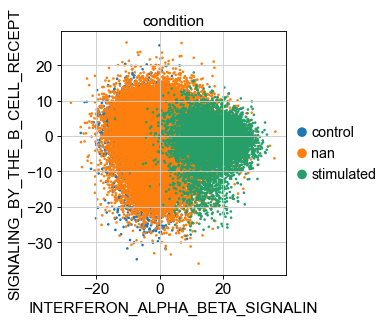

In [67]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_ALPHA_BETA_SIGNALIN', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition', size=22)

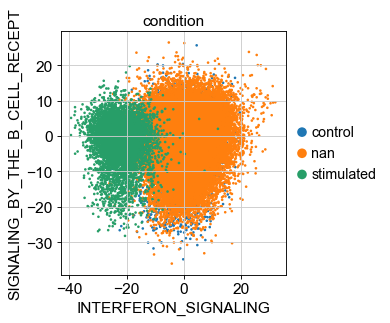

In [68]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_SIGNALING', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition', size=22)

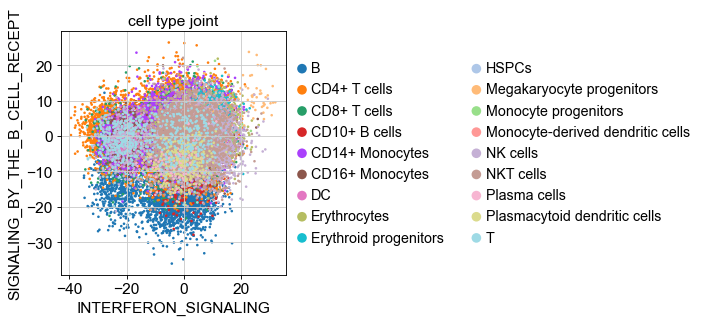

In [69]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_SIGNALING', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='cell_type_joint', size=22)

In [ ]:
#scvi

In [20]:
sca.dataset.setup_anndata(adata, batch_key="study")

INFO     Using batches from adata.obs["study"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 32484 cells, 1972 vars, 4 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [21]:
vae = sca.models.SCVI(
    adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [22]:
vae.train(max_epochs=500, early_stopping=True)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 317/500:  63%|█████████████████████████████▏                | 317/500 [31:44<18:19,  6.01s/it, loss=892, v_num=1]


In [23]:
vae_q = sca.models.SCVI.load_query_data(kang, vae, freeze_dropout=True)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 13576 cells, 1972 vars, 5 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


In [24]:
vae_q.train(max_epochs=500, early_stopping=True, plan_kwargs=dict(weight_decay=0.0))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 500/500: 100%|██████████████████████████████████████████████| 500/500 [14:56<00:00,  1.79s/it, loss=654, v_num=1]


In [26]:
kang_pbmc = sc.read('kang_pbmc.h5ad')

In [27]:
X_scvi = vae_q.get_latent_representation(kang_pbmc)

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 46060 cells, 1972 vars, 5 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


In [30]:
kang_pbmc.obsm['X_scvi'] = X_scvi

In [32]:
sc.pp.neighbors(kang_pbmc, use_rep='X_scvi')
sc.tl.umap(kang_pbmc)

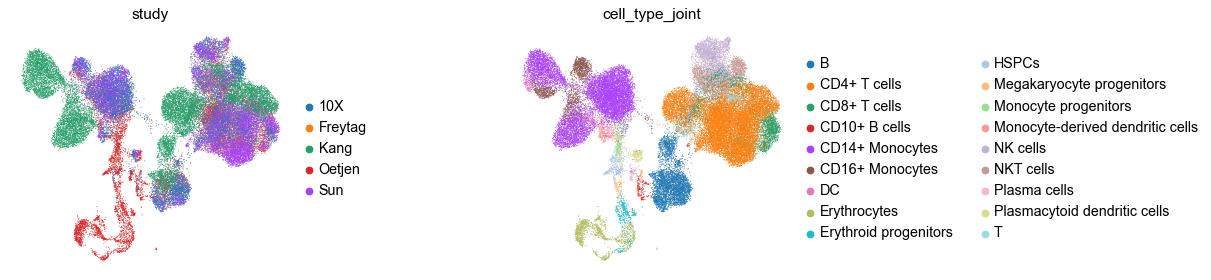

In [33]:
sc.pl.umap(kang_pbmc, color=['study', 'cell_type_joint'], frameon=False, wspace=0.6)

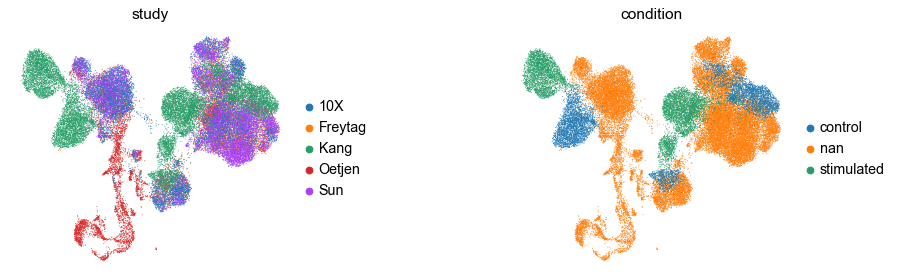

In [34]:
sc.pl.umap(kang_pbmc, color=['study', 'condition'], frameon=False, wspace=0.6)

In [36]:
pbmc = kang_pbmc[kang_pbmc.obs['study']!='Kang']

In [47]:
sc.pp.neighbors(pbmc, use_rep='X_scvi')
sc.tl.umap(pbmc)

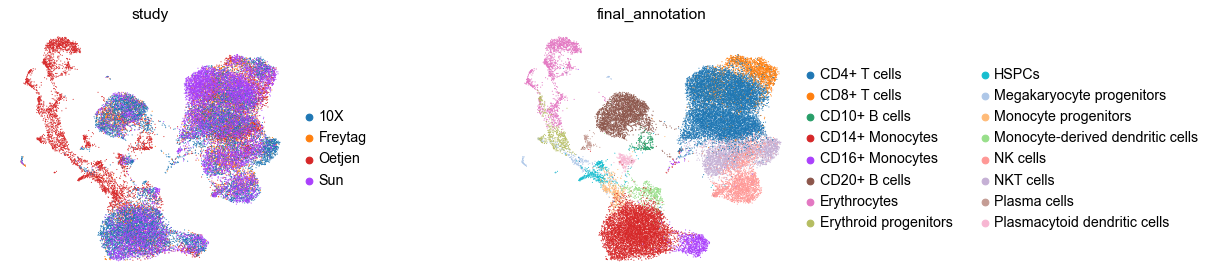

In [43]:
sc.pl.umap(pbmc, color=['study', 'final_annotation'], frameon=False, wspace=0.6)

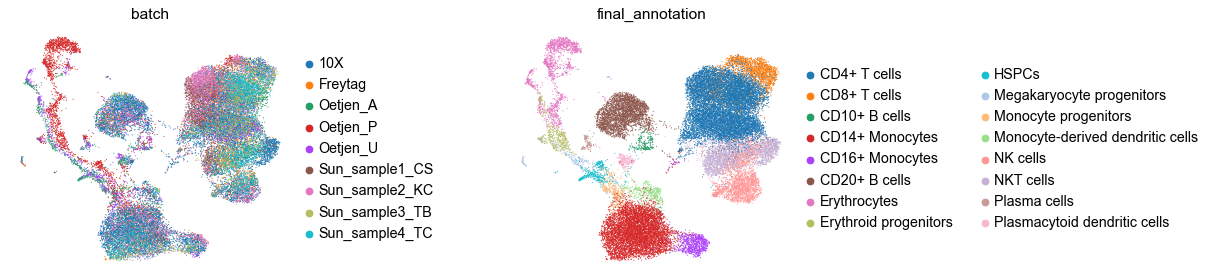

In [48]:
sc.pl.umap(pbmc, color=['batch', 'final_annotation'], frameon=False, wspace=0.6)

In [49]:
sc.pp.neighbors(pbmc, use_rep='X_cvae')
sc.tl.umap(pbmc)

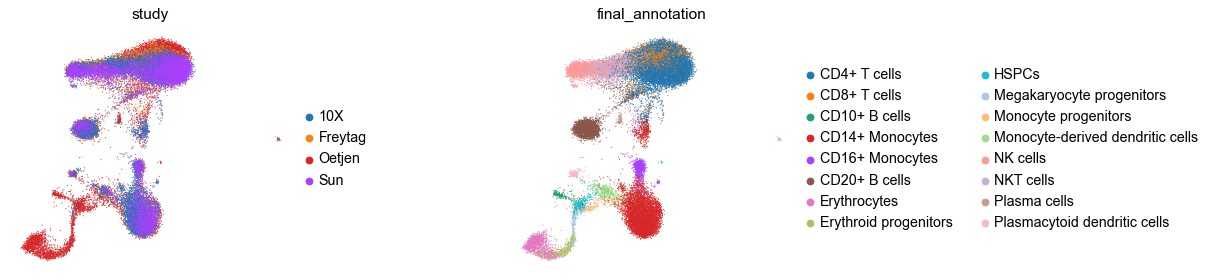

In [45]:
sc.pl.umap(pbmc, color=['study', 'final_annotation'], frameon=False, wspace=0.6)

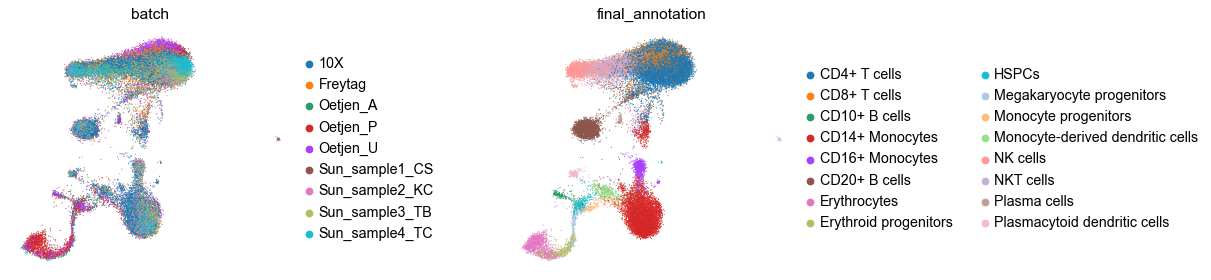

In [50]:
sc.pl.umap(pbmc, color=['batch', 'final_annotation'], frameon=False, wspace=0.6)

In [35]:
kang_pbmc.write('kang_pbmc.h5ad')